# Background
This notebook includes experiments to compare the accuracies and f1-scores of multiple preprocessing methods when applied before classification using ResNet50 (with epochs=100 and EarlyStopping)
* This notebook is written and run using Kaggle notebook. There might be some parts that need to be changed if ran using other tools.

# Setup

In [1]:
# set random seed to minimize randomness
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory   # load as tf.data.Dataset
from tensorflow.data.experimental import cardinality              # get total num of batches -> split val&test
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # data augmentation
from tensorflow.keras.applications.resnet50 import ResNet50       # ResNet50 base model
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [3]:
# SET CONSTANTS
IMG_DIR = '/kaggle/input/leukemia/Original'

IMG_SIZE = 224
NUM_CHANNELS = 3
NUM_CLASSES = 4
CLASS_NAMES = ['Benign', 'Early', 'Pre', 'Pro']

SHUFFLE_VALUE = True          # Shuffle images order
BATCH_SIZE = 8

VALIDATION_SPLIT = 0.3        # 70-30 train-val split
SEED_TRAIN_VAL = 420          # Must be same for train_ds and val_ds; reproducibility

# Load Data
To-do:<br>
[V] `label_mode='categorical'`

In [4]:
# get train images
raw_train_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "training",        # specify training subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

raw_val_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "validation",      # specify validation subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

# split validation subset into 2: val & test
val_batches = cardinality(raw_val_ds)
raw_test_ds = raw_val_ds.take((2*val_batches) // 3)
raw_val_ds = raw_val_ds.skip((2*val_batches) // 3)

Found 3256 files belonging to 4 classes.
Using 2280 files for training.
Found 3256 files belonging to 4 classes.
Using 976 files for validation.


**Show 1 batch as sample**

In [5]:
def plot_batch(ds,title=''):
  plt.figure(figsize=(BATCH_SIZE*3, 9))
  plt.suptitle(title,fontweight='bold',fontsize=20)
  for images, labels in ds.take(1):
      for i in range(BATCH_SIZE):
          ax = plt.subplot(3, BATCH_SIZE, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(CLASS_NAMES[np.argmax(labels[i].numpy(), axis=-1)])
          plt.axis("off")

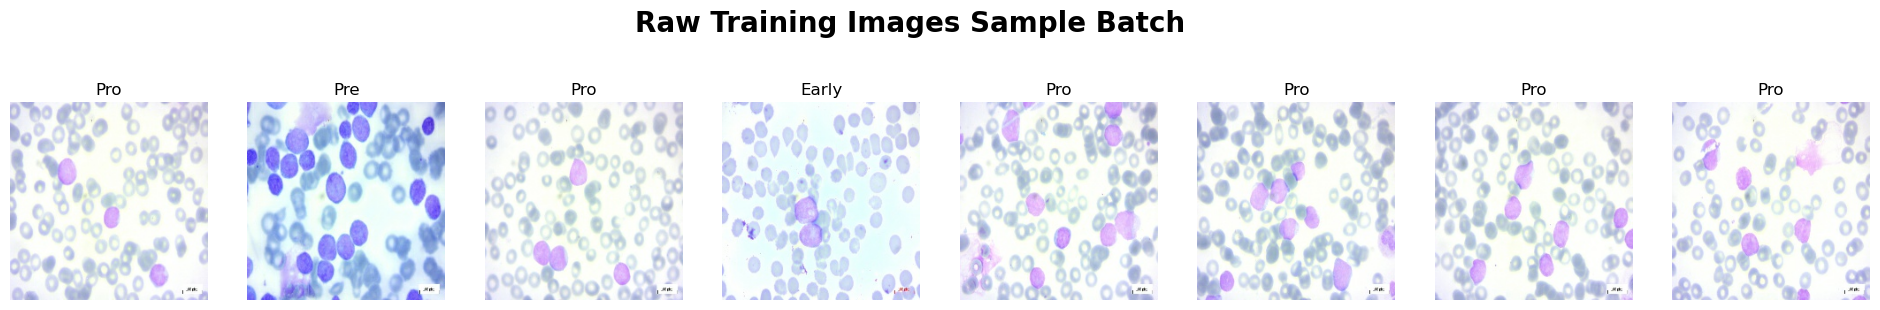

In [6]:
plot_batch(raw_train_ds,'Raw Training Images Sample Batch')

# Method 0: Raw Image + Train Data Augmentation to Avoid Overfitting

In [7]:
class method0:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None,NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds

In [8]:
train0_ds = method0().train(raw_train_ds,BATCH_SIZE)
val0_ds = method0().val_test(raw_val_ds,BATCH_SIZE)
test0_ds = method0().val_test(raw_test_ds,BATCH_SIZE)

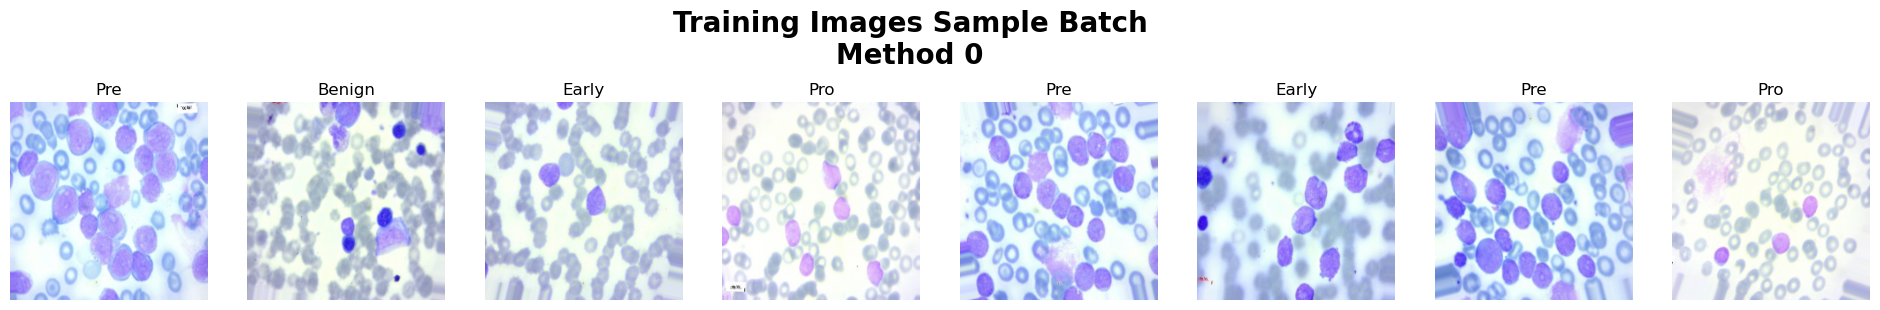

In [9]:
plot_batch(train0_ds,'Training Images Sample Batch\nMethod 0')

# Method 1 (No Segmentation) Histogram Equalization
Originally the output images of this method were supposed to be in HSV, however VGG19 requires BGR input and `preprocess_input()` function automatically assumes the input is in RGB and convert it to BGR. So HSV conversion doesn't really make sense.

In [10]:
class method1:
  # preprocessing -> enhance data quality
  def preprocess_cv(self,img,lbl):
    img = img.numpy().astype('uint8')
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # histogram equalization
    channels = cv2.split(img_lab)
    cv2.equalizeHist(channels[0],channels[0])
    img_lab_histeq = cv2.merge(channels)
    # turn to hsv
    img_rgb_histeq = cv2.cvtColor(img_lab_histeq, cv2.COLOR_LAB2RGB)
    # img_hsv_histeq = cv2.cvtColor(img_rgb_histeq, cv2.COLOR_RGB2HSV) # doesn't make sense
    return img_rgb_histeq,lbl

  def preprocess_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.preprocess_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    prep_ds = ds.unbatch().map(self.preprocess_pyfunction).batch(batch_size)
    aug_ds = prep_ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    prep_ds = ds.unbatch().map(self.preprocess_pyfunction).batch(batch_size)
    aug_ds = prep_ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds

In [11]:
train1_ds = method1().train(raw_train_ds,BATCH_SIZE)
val1_ds = method1().val_test(raw_val_ds,BATCH_SIZE)
test1_ds = method1().val_test(raw_test_ds,BATCH_SIZE)

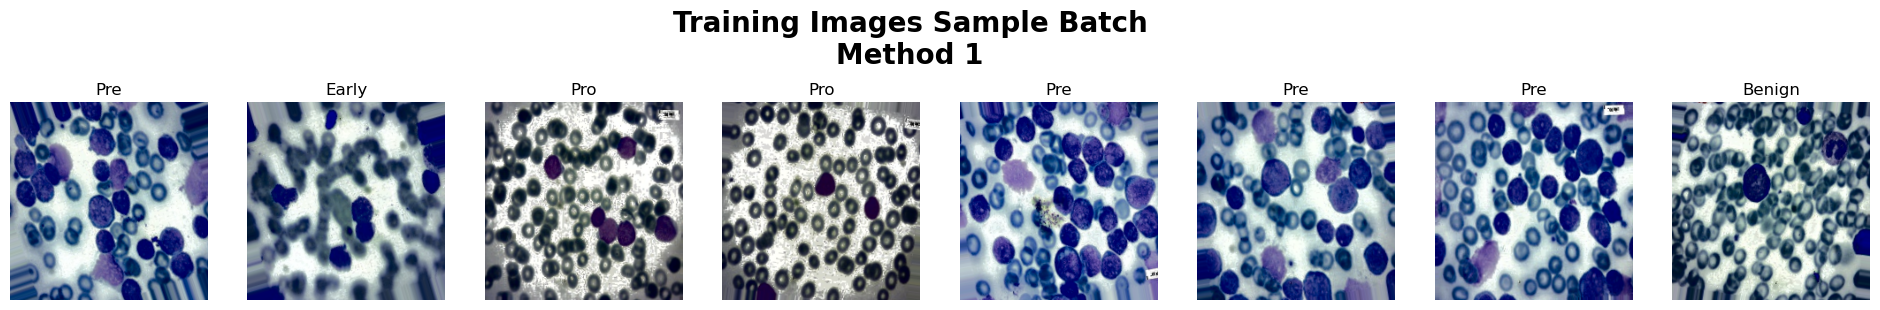

In [12]:
plot_batch(train1_ds,'Training Images Sample Batch\nMethod 1')

# Method 2: (Segmented) Using S-channel in HSV (**Without** Hist Equ), **Without** Watershed

In [13]:
class method2:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # segmentation
  def segment_cv(self,img,lbl):
    # convert to HSV
    img = img.numpy().astype('uint8')
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # mask
    # thresholding
    sat_hsv = img_hsv[:,:,1]
    ret_hsv,th_hsv = cv2.threshold(sat_hsv,90,255,cv2.THRESH_BINARY)
    # opening
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    opening_hsv = cv2.morphologyEx(th_hsv, cv2.MORPH_OPEN, kernel_opening)

    # apply mask
    img_applied = cv2.bitwise_and(img,img,mask=opening_hsv)
    return img_applied,lbl

  def segment_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.segment_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds

In [14]:
train2_ds = method2().train(raw_train_ds,BATCH_SIZE)
val2_ds = method2().val_test(raw_val_ds,BATCH_SIZE)
test2_ds = method2().val_test(raw_test_ds,BATCH_SIZE)

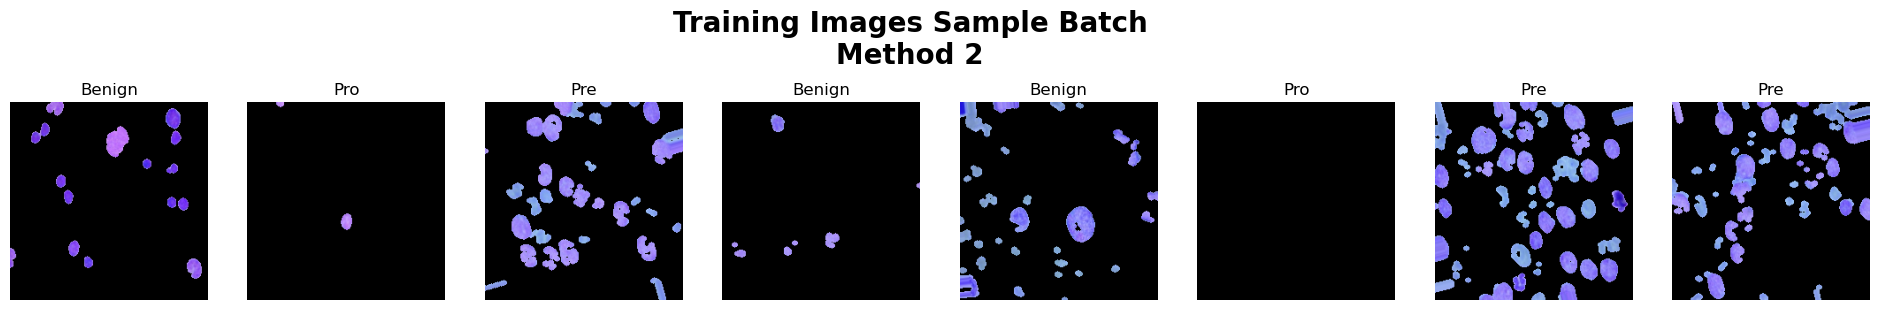

In [15]:
plot_batch(train2_ds,'Training Images Sample Batch\nMethod 2')

# Method 3: (Segmented) Using S-channel in HSV (**Without** Hist Equ), **With** Watershed

In [16]:
class method3:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # segmentation
  def segment_cv(self,img,lbl):
    # convert to HSV
    img = img.numpy().astype('uint8')
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # mask
    # thresholding
    sat_hsv = img_hsv[:,:,1]
    ret_hsv,th_hsv = cv2.threshold(sat_hsv,90,255,cv2.THRESH_BINARY)
    # opening
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    opening_hsv = cv2.morphologyEx(th_hsv, cv2.MORPH_OPEN, kernel_opening)
    # dilation
    kernel_dilation = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    dilated_hsv = cv2.dilate(opening_hsv, kernel_dilation)
    # watershed
    unknown = cv2.subtract(dilated_hsv,opening_hsv)
    markers = opening_hsv.astype('int32')
    markers[markers==225] = 1
    markers = markers+1           # +1 to all labels so that sure background is not 0, but 1
    markers[unknown==225] = 0     # mark the region of the unknown with zero
    finalmask = cv2.watershed(img,markers)
    finalmask[finalmask == 1] = 0
    finalmask[finalmask == -1] = 0
    finalmask[finalmask != 0] = 255

    # apply mask
    img_applied = cv2.bitwise_and(img,img,mask=finalmask.astype(np.uint8))
    return img_applied,lbl

  def segment_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.segment_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds

In [17]:
train3_ds = method3().train(raw_train_ds,BATCH_SIZE)
val3_ds = method3().val_test(raw_val_ds,BATCH_SIZE)
test3_ds = method3().val_test(raw_test_ds,BATCH_SIZE)

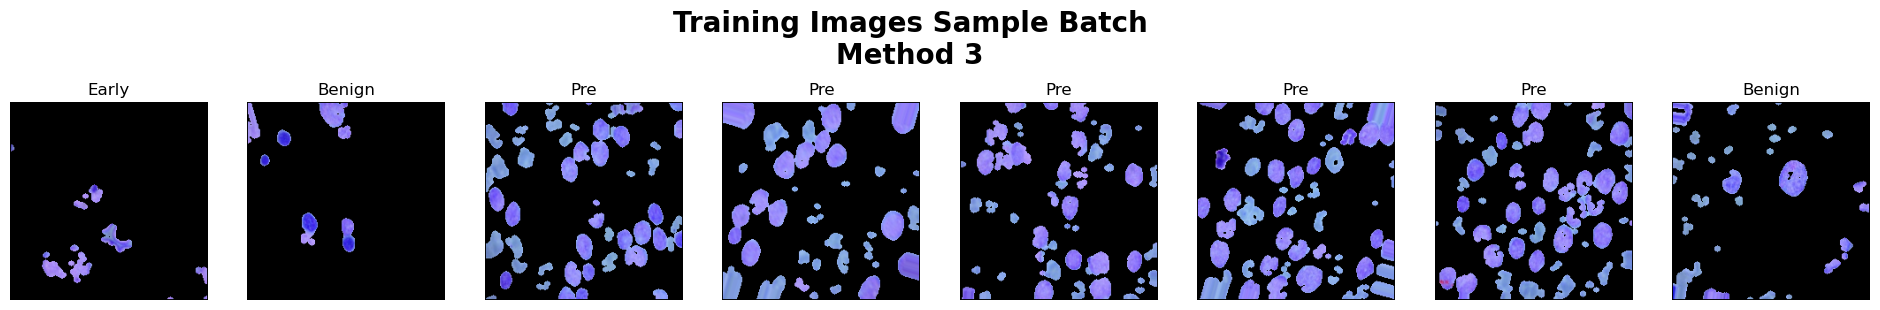

In [18]:
plot_batch(train3_ds,'Training Images Sample Batch\nMethod 3')

# Method 4: (Segmented) Using S-channel in HSV (**With** Hist Equ), **Without** Watershed

In [19]:
class method4:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # segmentation
  def segment_cv(self,img,lbl):
    img = img.numpy().astype('uint8')
    # convert to LAB
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # histogram equalization
    channels = cv2.split(img_lab)
    cv2.equalizeHist(channels[0],channels[0])
    img_lab_histeq = cv2.merge(channels)
    # turn to hsv
    img_rgb_histeq = cv2.cvtColor(img_lab_histeq, cv2.COLOR_LAB2RGB)
    img_hsv_histeq = cv2.cvtColor(img_rgb_histeq, cv2.COLOR_RGB2HSV)

    # mask
    # thresholding
    sat_hsv = img_hsv_histeq[:,:,1]
    ret_hsv,th_hsv = cv2.threshold(sat_hsv,200,255,cv2.THRESH_BINARY)
    # opening
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    opening_hsv = cv2.morphologyEx(th_hsv, cv2.MORPH_OPEN, kernel_opening)

    # apply mask
    img_applied = cv2.bitwise_and(img,img,mask=opening_hsv)
    return img_applied,lbl

  def segment_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.segment_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl

  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds

In [20]:
train4_ds = method4().train(raw_train_ds,BATCH_SIZE)
val4_ds = method4().val_test(raw_val_ds,BATCH_SIZE)
test4_ds = method4().val_test(raw_test_ds,BATCH_SIZE)

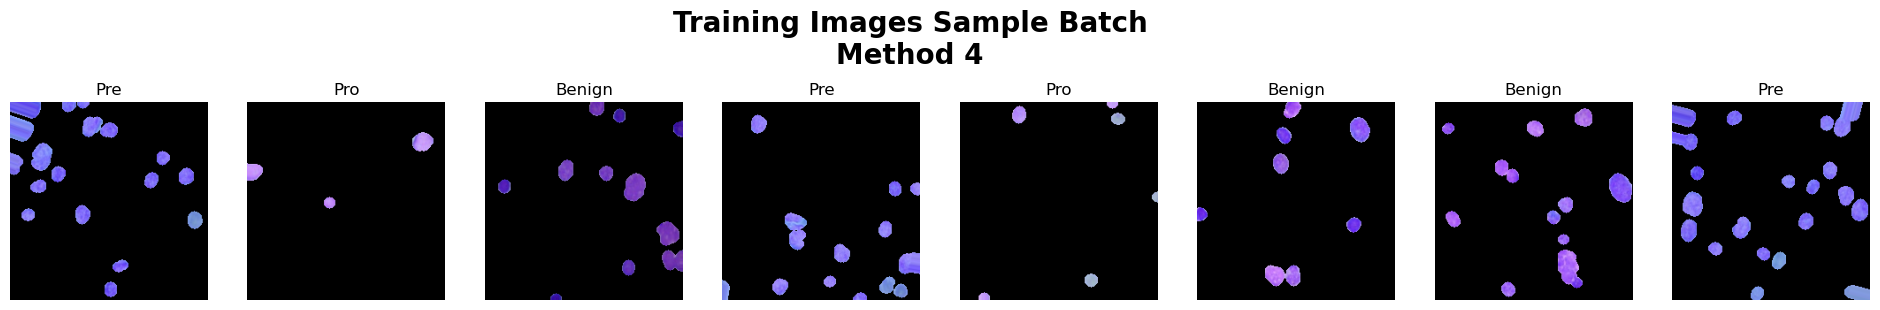

In [21]:
plot_batch(train4_ds,'Training Images Sample Batch\nMethod 4')

# Method 5: (Segmented) Using S-channel in HSV (**With** Hist Equ), **With** Watershed

In [22]:
class method5:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # segmentation
  def segment_cv(self,img,lbl):
    img = img.numpy().astype('uint8')
    # convert to LAB
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # histogram equalization
    channels = cv2.split(img_lab)
    cv2.equalizeHist(channels[0],channels[0])
    img_lab_histeq = cv2.merge(channels)
    # turn to hsv
    img_rgb_histeq = cv2.cvtColor(img_lab_histeq, cv2.COLOR_LAB2RGB)
    img_hsv_histeq = cv2.cvtColor(img_rgb_histeq, cv2.COLOR_RGB2HSV)

    # mask
    # thresholding
    sat_hsv = img_hsv_histeq[:,:,1]
    ret_hsv,th_hsv = cv2.threshold(sat_hsv,200,255,cv2.THRESH_BINARY)
    # opening
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    opening_hsv = cv2.morphologyEx(th_hsv, cv2.MORPH_OPEN, kernel_opening)
    # dilation
    kernel_dilation = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    dilated_hsv = cv2.dilate(opening_hsv, kernel_dilation)
    # watershed
    unknown = cv2.subtract(dilated_hsv,opening_hsv)
    markers = opening_hsv.astype('int32')
    markers[markers==225] = 1
    markers = markers+1           # +1 to all labels so that sure background is not 0, but 1
    markers[unknown==225] = 0     # mark the region of the unknown with zero
    finalmask = cv2.watershed(img,markers)
    finalmask[finalmask == 1] = 0
    finalmask[finalmask == -1] = 0
    finalmask[finalmask != 0] = 255

    # apply mask
    img_applied = cv2.bitwise_and(img,img,mask=finalmask.astype(np.uint8))
    return img_applied,lbl

  def segment_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.segment_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl
  
  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl

  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds

In [23]:
train5_ds = method5().train(raw_train_ds,BATCH_SIZE)
val5_ds = method5().val_test(raw_val_ds,BATCH_SIZE)
test5_ds = method5().val_test(raw_test_ds,BATCH_SIZE)

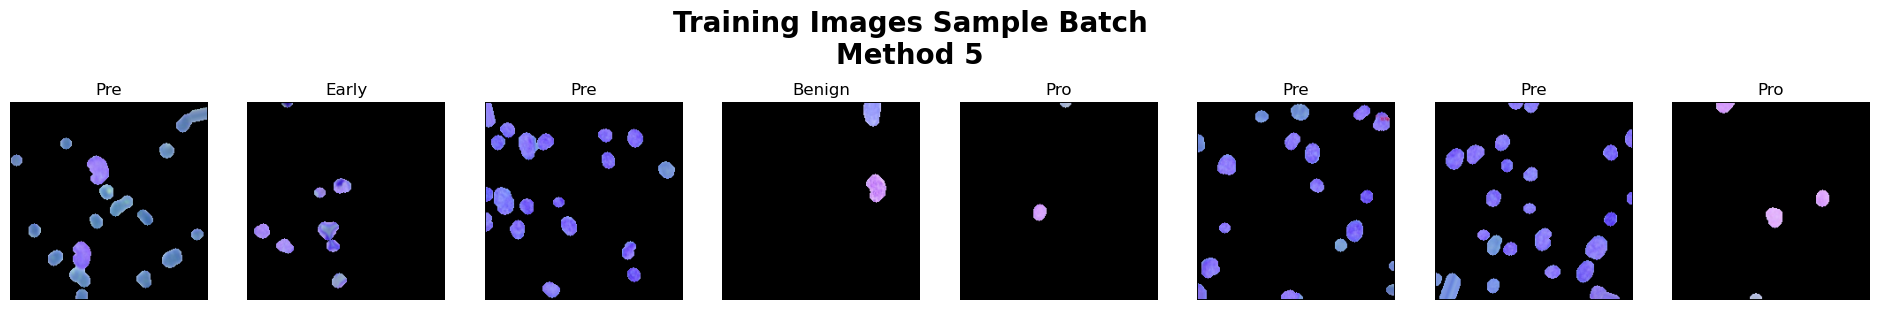

In [24]:
plot_batch(train5_ds,'Training Images Sample Batch\nMethod 5')

# Method 6: (Segmented) Using A-channel in LAB, **With** Watershed

In [25]:
class method6:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # segmentation
  def segment_cv(self,img,lbl):
    img = img.numpy().astype('uint8')
    # convert to LAB
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # mask
    # thresholding
    a_lab = img_lab[:,:,1]
    ret_lab,th_lab = cv2.threshold(a_lab,145,255,cv2.THRESH_BINARY)
    # opening
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    opening_lab = cv2.morphologyEx(th_lab, cv2.MORPH_OPEN, kernel_opening)
    # dilation
    kernel_dilation = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    dilated_lab = cv2.dilate(opening_lab, kernel_dilation)
    # watershed
    unknown = cv2.subtract(dilated_lab,opening_lab)
    markers = opening_lab.astype('int32')
    markers[markers==225] = 1
    markers = markers+1           # +1 to all labels so that sure background is not 0, but 1
    markers[unknown==225] = 0     # mark the region of the unknown with zero
    finalmask = cv2.watershed(img,markers)
    finalmask[finalmask == 1] = 0
    finalmask[finalmask == -1] = 0
    finalmask[finalmask != 0] = 255

    # apply mask
    img_applied = cv2.bitwise_and(img,img,mask=finalmask.astype(np.uint8))
    return img_applied,lbl

  def segment_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.segment_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    seg_ds = aug_ds.unbatch().map(self.segment_pyfunction).batch(batch_size)
    fin_ds = seg_ds.map(self._fixup_shape)
    return fin_ds

In [26]:
train6_ds = method6().train(raw_train_ds,BATCH_SIZE)
val6_ds = method6().val_test(raw_val_ds,BATCH_SIZE)
test6_ds = method6().val_test(raw_test_ds,BATCH_SIZE)

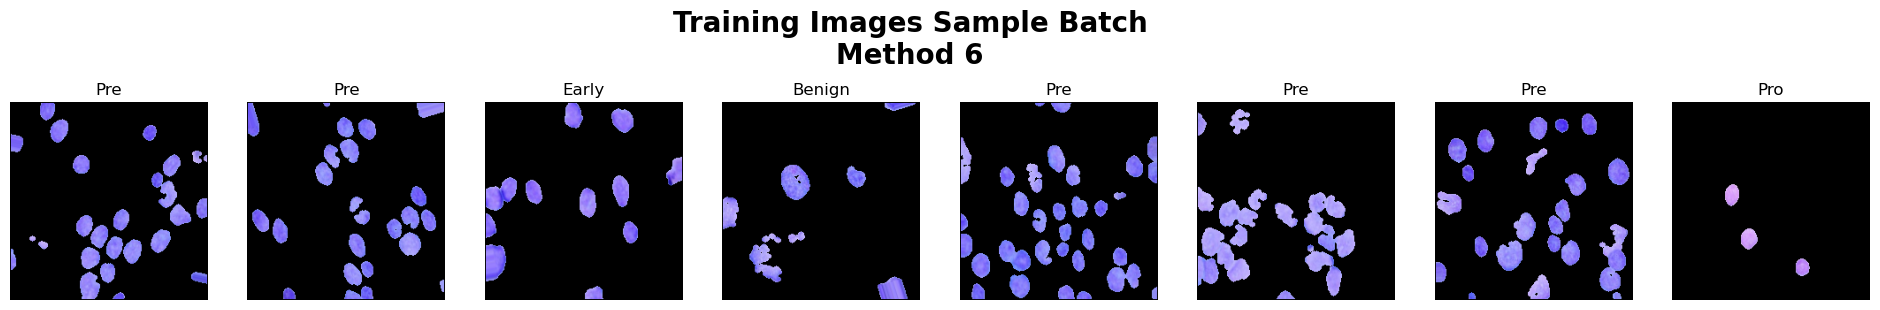

In [27]:
plot_batch(train6_ds,'Training Images Sample Batch\nMethod 6')

# Classification Model and Comparison
To-do:<br>
[V] Add early stopping<br>
[V] Add save command for the best model during training<br>
[V] `loss='categorical_crossentropy'`<br>
[V] Increase training epochs = 100<br>

In [28]:
#Create metrics. Code from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [29]:
def pre_rn50(img,lbl):
  return tf.keras.applications.resnet50.preprocess_input(img),lbl

In [30]:
def get_rn50_hist_rep(train_ds,val_ds,test_ds,num_epoch1=3,num_epoch2=10,method=''):
  # Reference: https://www.kaggle.com/code/drscarlat/melanoma-resnet50-fine-tune/notebook
  # Preprocess_Input
  train_ds = train_ds.map(pre_rn50)
  val_ds = val_ds.map(pre_rn50)
  test_ds = test_ds.map(pre_rn50)

  # Convoluted Base MODEL
  conv_base = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

  # MODEL
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  # Make the conv_base NOT trainable:
  for layer in conv_base.layers[:]:
    layer.trainable = False

  # Compile frozen conv_base + my top layer
  model.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy',f1_m])

  # Short training ONLY my top layers 
  #... so the conv_base weights will not be destroyed by the random intialization of the new weights
  history = model.fit(train_ds,
                      epochs=num_epoch1,
                      validation_data = val_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False)

  # Make last block of the conv_base trainable:
  for layer in conv_base.layers[:165]:
    layer.trainable = False
  for layer in conv_base.layers[165:]:
    layer.trainable = True

  model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy',f1_m])
  
  # set callbacks
  model_filename = f'/kaggle/working/models/all_rn50_{method}.h5'
  save_best_model = ModelCheckpoint(filepath = model_filename,
                                   monitor = 'val_f1_m',
                                   mode = 'max',
                                   verbose = 1,
                                   save_best_only = True)
  early_stopping = EarlyStopping(monitor='val_f1_m',patience=5,mode='max')

  history = model.fit(train_ds,
                      epochs=num_epoch2,
                      validation_data = val_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      callbacks=[save_best_model,early_stopping])
  
  y_pred = []  # store predicted labels
  y_true = []  # store true labels
  # iterate over the dataset
  for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    truth = np.argmax(label_batch, axis=1)
    y_true.append(truth)
    # compute predictions
    preds = model.predict(image_batch,verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)
  report = classification_report(correct_labels, predicted_labels, digits= 4, output_dict=True,)
  report_df = pd.DataFrame(report).transpose()

  return history,report_df

In [31]:
def get_rn50_all(trains=[],vals=[],tests=[],num_epoch1=3,num_epoch2=10):
  method_cnt = -1
  histories = []
  reports = []
  acc_tests = []
  f1_tests = []
  for train_ds, val_ds, test_ds in zip(trains,vals,tests):
    method_cnt += 1
    print(f'STARTING METHOD-{method_cnt}')
    hist, rep = get_rn50_hist_rep(train_ds,val_ds,test_ds,num_epoch1=num_epoch1,num_epoch2=num_epoch2,method=f'method{method_cnt}')
    histories.append(hist)
    reports.append(rep)
    # Accuracy for the test dataset
    acc = {}
    acc['method'] = f'Method {method_cnt}'
    acc['accuracy'] = rep['f1-score']['accuracy']
    acc_tests.append(acc)
    # F1 for the test dataset
    for i in range(NUM_CLASSES):
      f1 = {}
      f1['method'] = f'Method {method_cnt}'
      f1['label'] = i
      f1['f1-score'] = rep['f1-score'][i]
      f1_tests.append(f1)

  # SIDE BY SIDE
  # plot training acc
  fig1, axes1 = plt.subplots(ncols=2,nrows=1,figsize=(40,10))
  fig1.subplots_adjust(top=0.8)
  col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
  for i in range(len(histories)):
    acc = histories[i].history['accuracy']
    epochs = range(1, len(acc) + 1)
    axes1[0].plot(epochs, acc, 'r', label=f'Method {i} acc', color=col[i])
  axes1[0].set_title('Training Accuracies of Each Method',fontweight='bold',fontsize=20)
  axes1[0].legend()
  # plot validation acc
  for i in range(len(histories)):
    val_acc = histories[i].history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)
    axes1[1].plot(epochs, val_acc, 'r', label=f'Method {i} val acc', color=col[i])
  axes1[1].set_title('Validation Accuracies of Each Method',fontweight='bold',fontsize=20)
  axes1[1].legend()
  plt.show()

  # SIDE BY SIDE
  # plot training f1_m
  fig2, axes2 = plt.subplots(ncols=2,nrows=1,figsize=(40,10))
  fig2.subplots_adjust(top=0.8)
  col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
  for i in range(len(histories)):
    f1_m = histories[i].history['f1_m']
    epochs = range(1, len(f1_m) + 1)
    axes2[0].plot(epochs, f1_m, 'r', label=f'Method {i} f1_m', color=col[i])
  axes2[0].set_title('Training F1-Scores of Each Method',fontweight='bold',fontsize=20)
  axes2[0].legend()
  # plot validation acc
  for i in range(len(histories)):
    val_f1_m = histories[i].history['val_f1_m']
    epochs = range(1, len(val_f1_m) + 1)
    axes2[1].plot(epochs, val_f1_m, 'r', label=f'Method {i} val f1_m', color=col[i])
  axes2[1].set_title('Validation F1-Scores of Each Method',fontweight='bold',fontsize=20)
  axes2[1].legend()
  plt.show()

  # BAR PLOT
  # accuracy
  acc_tests = pd.DataFrame(acc_tests)
  fig_acc_test = plt.figure(figsize=(20,10))
  ax1 = sns.barplot(data=acc_tests,x='method',y='accuracy')
  # For each bar, grab its coordinates and colors, find a suitable location
  # for a text and place it there.
  for patch in ax1.patches:
      x0, y0 = patch.get_xy()   # Bottom-left corner. 
      x0 += patch.get_width()/2 # Middle of the width.
      y0 += patch.get_height()  # Top of the bar
      ax1.text(x0, y0, str("{:.2f}".format(y0)), ha="center", va="bottom",color='black', clip_on=True)
  plt.title('Test Accuracy Comparison\nFor Each Method',fontweight='bold',fontsize=20)
  plt.show()
  # f1
  f1_tests = pd.DataFrame(f1_tests)
  fig_f1_test = plt.figure(figsize=(20,10))
  ax2 = sns.barplot(data=f1_tests,x='label',y='f1-score',hue='method')
  for patch in ax2.patches:
      x0, y0 = patch.get_xy()   # Bottom-left corner. 
      x0 += patch.get_width()/2 # Middle of the width.
      y0 += patch.get_height()  # Top of the bar
      ax2.text(x0, y0, str("{:.2f}".format(y0)), ha="center", va="bottom",color='black', clip_on=True)
  plt.title('Categorical F1-Score Comparison\nFor Each Method',fontweight='bold',fontsize=20)
  plt.show()

  return histories, reports

STARTING METHOD-0
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/3
285/285 [==============================] - 52s 143ms/step - loss: 2.2828 - accuracy: 0.6368 - f1_m: 0.4978 - val_loss: 0.9142 - val_accuracy: 0.8049 - val_f1_m: 0.6169
Epoch 2/3
285/285 [==============================] - 37s 130ms/step - loss: 0.9933 - accuracy: 0.6570 - f1_m: 0.5114 - val_loss: 0.7581 - val_accuracy: 0.8079 - val_f1_m: 0.6376
Epoch 3/3
285/285 [==============================] - 37s 131ms/step - loss: 0.9320 - accuracy: 0.6807 - f1_m: 0.5433 - val_loss: 0.7853 - val_accuracy: 0.7774 - val_f1_m: 0.6010
Epoch 1/100
    285/Unknown - 41s 121ms/step - loss: 0.9351 - accuracy: 0.6662 - f1_m: 0.5185
Epoch 1: val_f1_m improved from -inf to 0.62839, saving model to /kaggle/working/models/all_rn50_method0.h5
285/285 [==============================] - 45s 135ms/step - loss: 0.9351 - accuracy: 0.6662 - f1_m: 0.5185 - val_loss: 0.7211 - val_accuracy: 0.8049 - val_f1_m: 0.6284
Epoch 2/100
2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


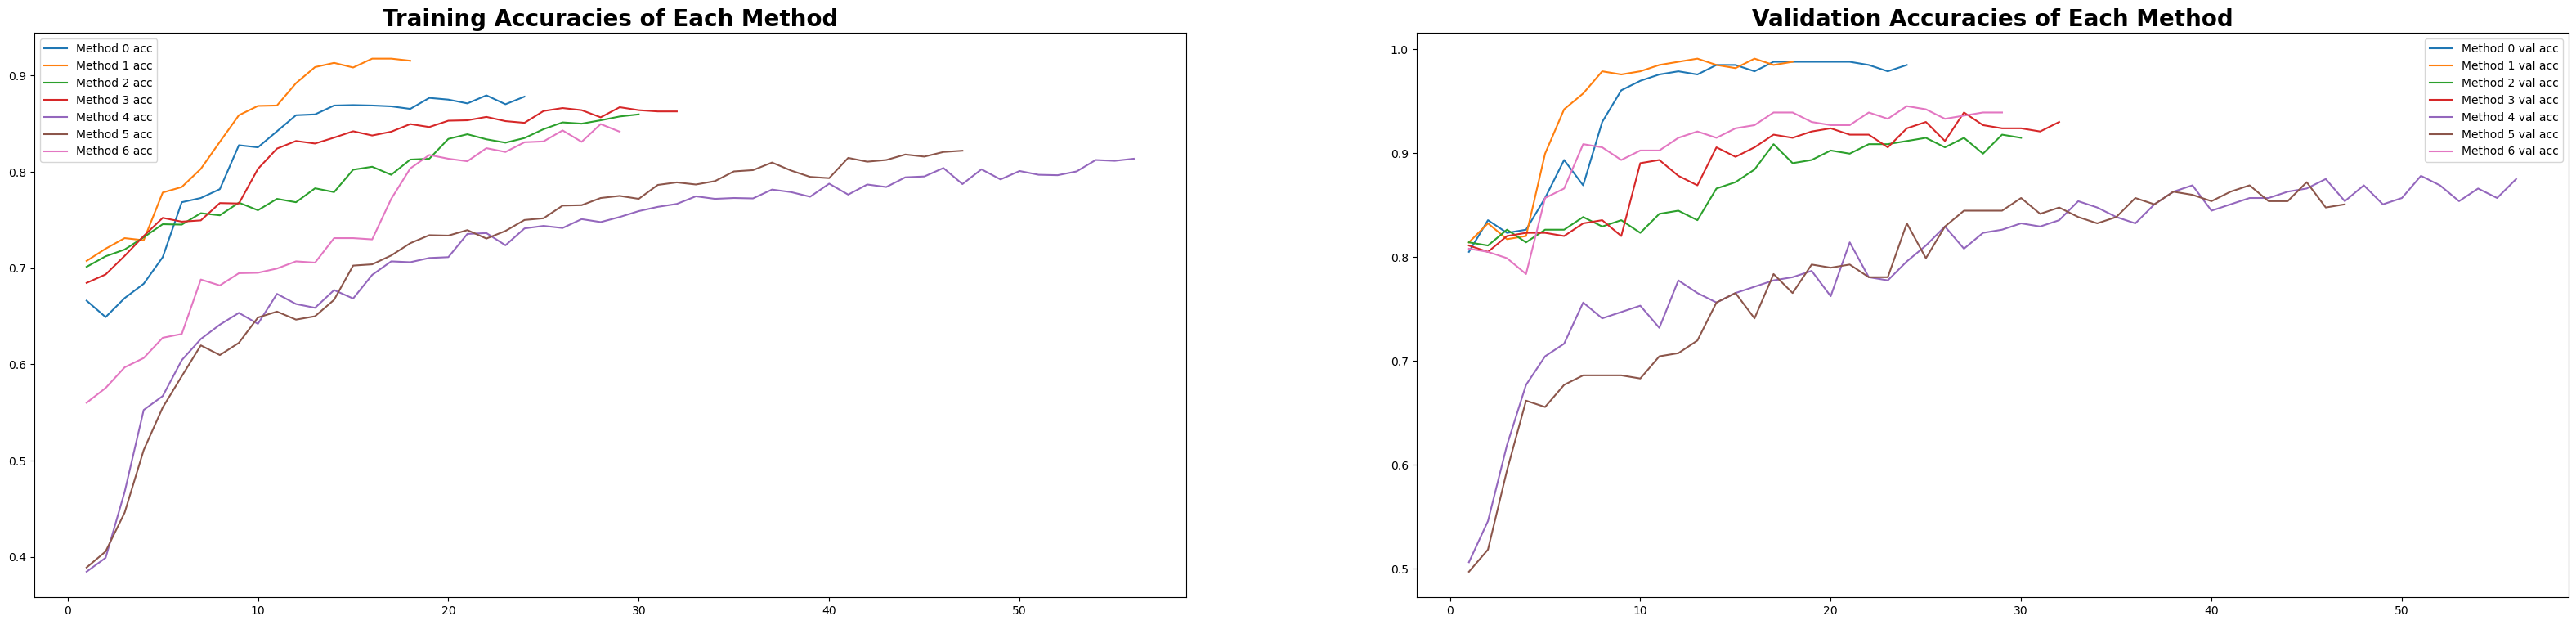

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


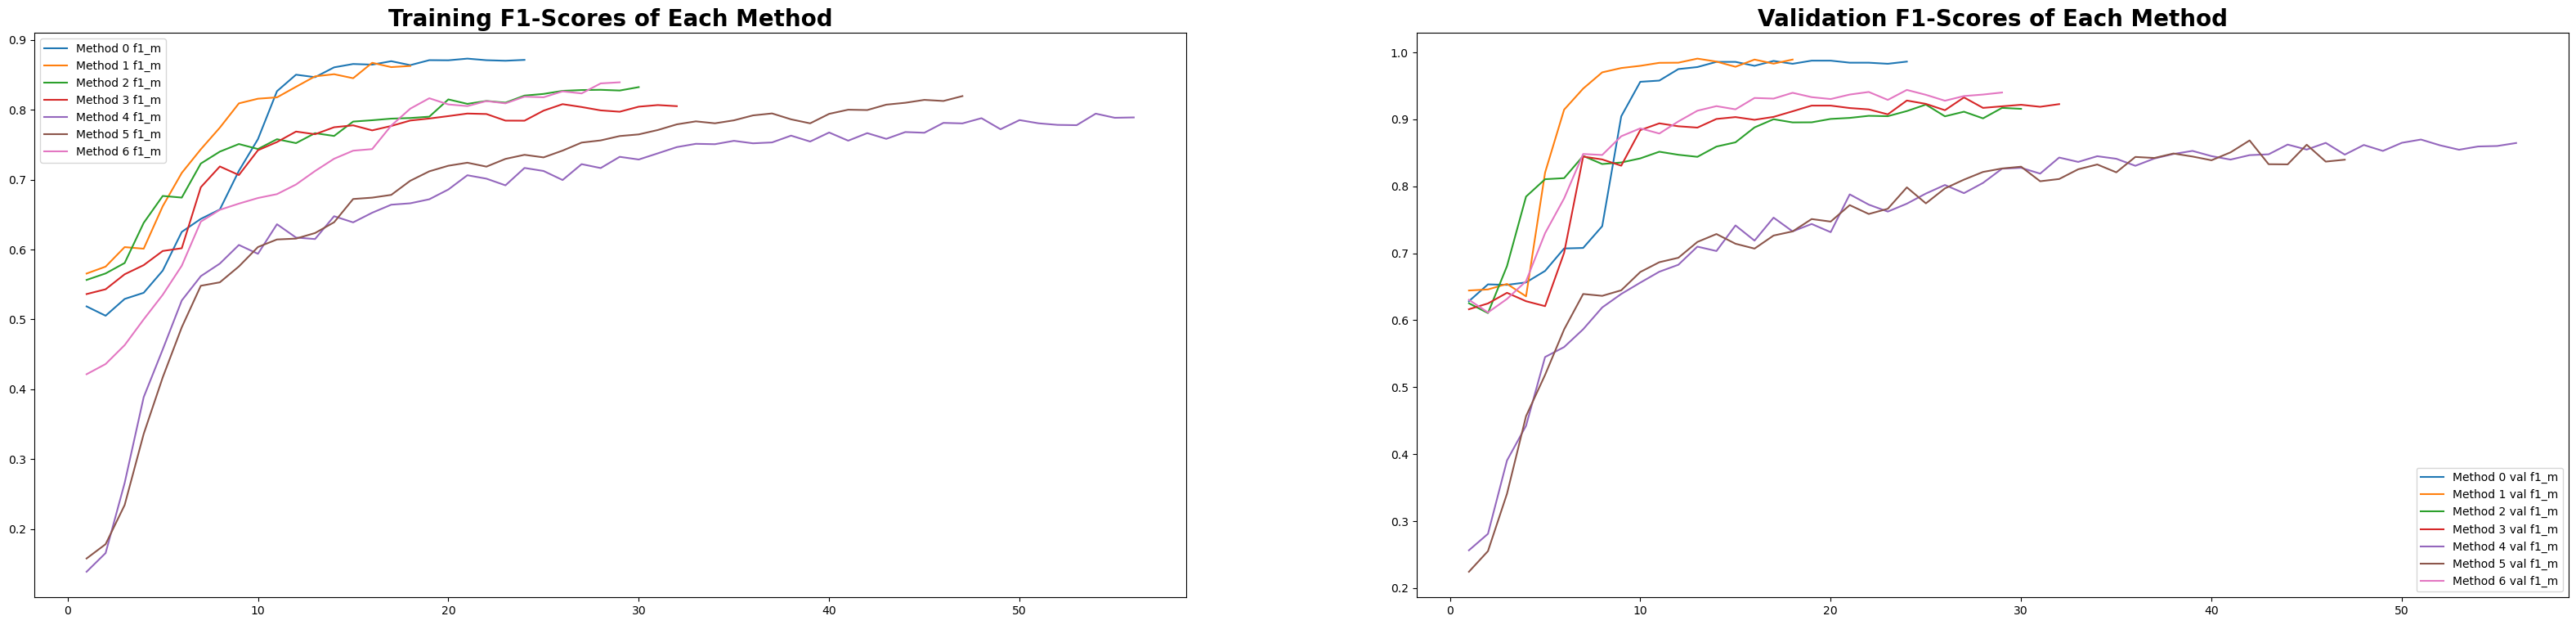

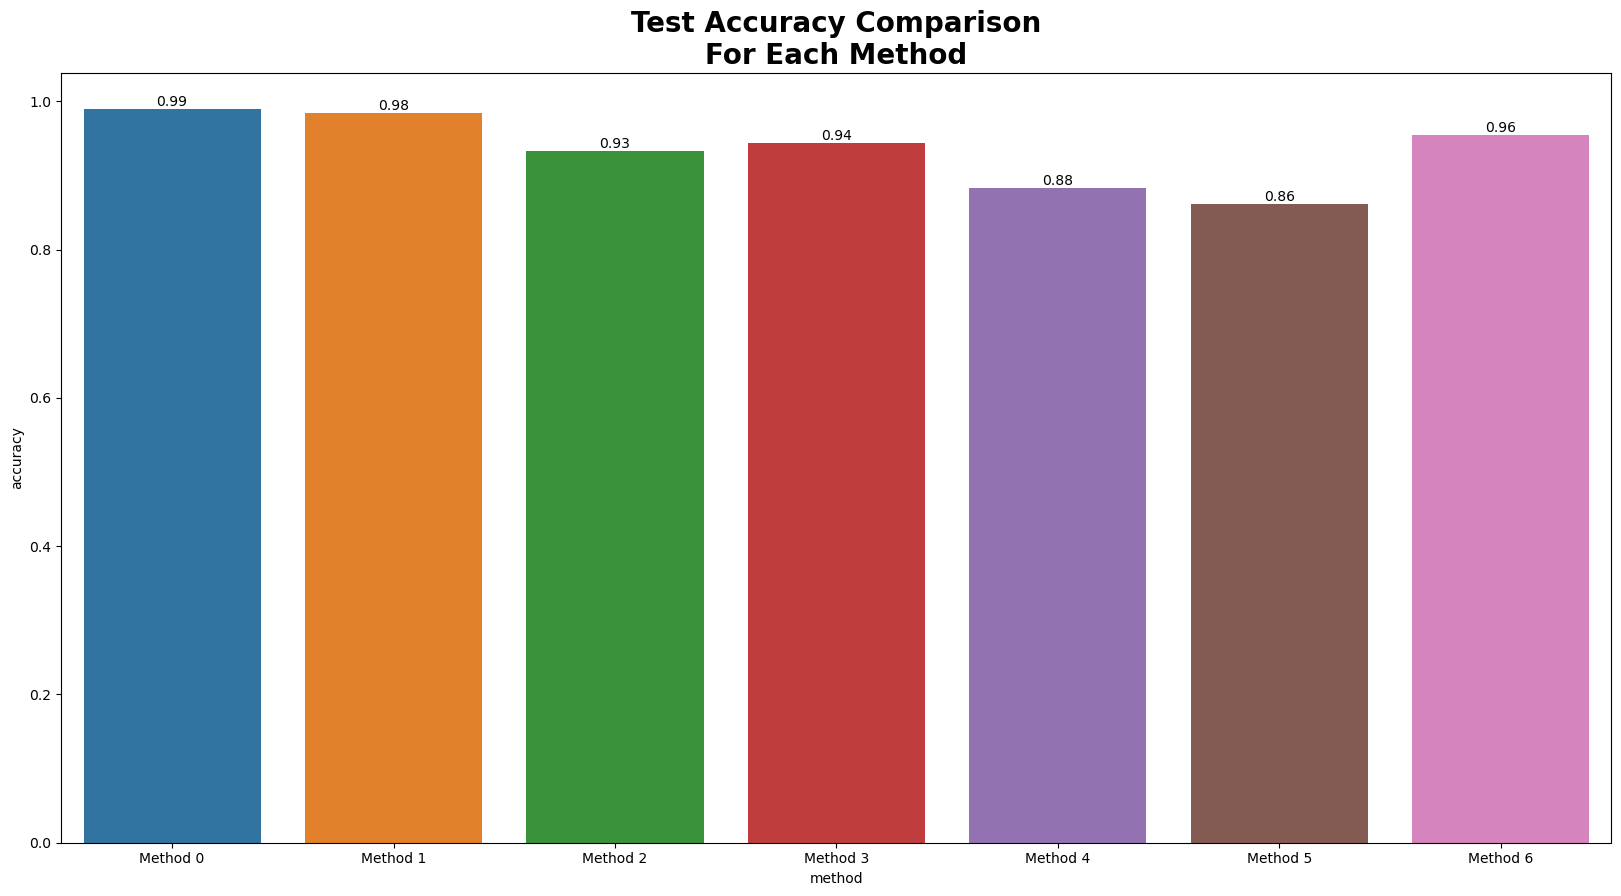

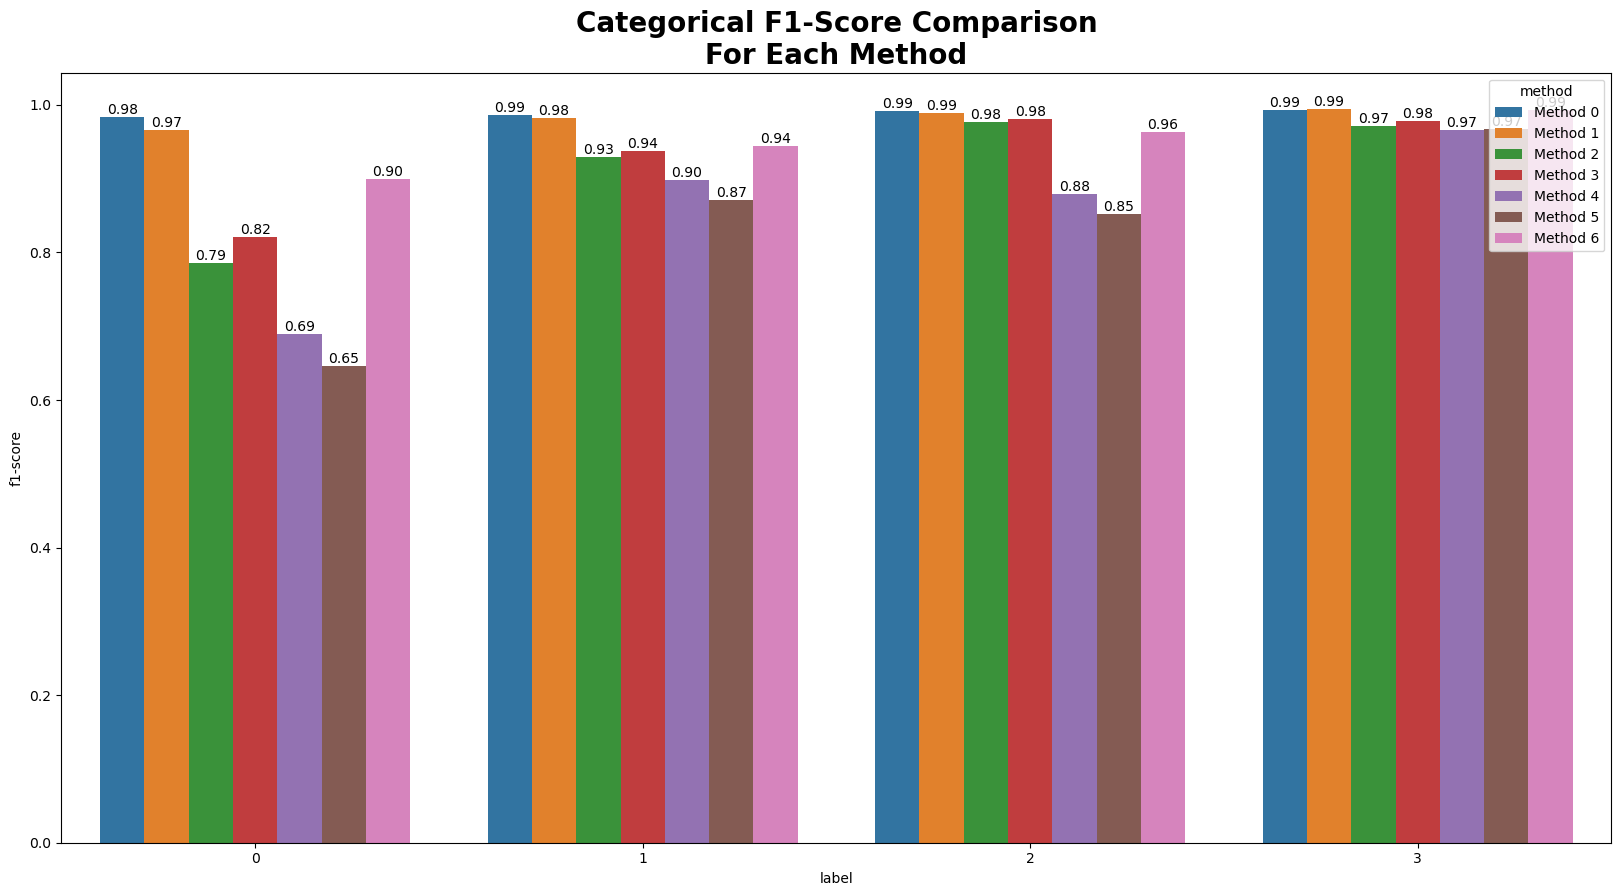

In [32]:
trains = [train0_ds,train1_ds,train2_ds,train3_ds,train4_ds,train5_ds,train6_ds]
vals = [val0_ds,val1_ds,val2_ds,val3_ds,val4_ds,val5_ds,val6_ds]
tests = [test0_ds,test1_ds,test2_ds,test3_ds,test4_ds,test5_ds,test6_ds]
histories, reports = get_rn50_all(trains=trains,vals=vals,tests=tests,num_epoch1=3,num_epoch2=100)

In [33]:
reports[0]

,precision,recall,f1-score,support
0,0.967391,1.000000,0.983425,89.000000
1,0.986111,0.986111,0.986111,216.000000
2,1.000000,0.983957,0.991914,187.000000
3,0.993590,0.993590,0.993590,156.000000
accuracy,0.989198,0.989198,0.989198,0.989198
macro avg,0.986773,0.990915,0.988760,648.000000
weighted avg,0.989348,0.989198,0.989217,648.000000


In [34]:
reports[1]

,precision,recall,f1-score,support
0,0.988506,0.945055,0.966292,91.000000
1,0.968468,0.995370,0.981735,216.000000
2,0.994318,0.983146,0.988701,178.000000
3,0.993865,0.993865,0.993865,163.000000
accuracy,0.984568,0.984568,0.984568,0.984568
macro avg,0.986289,0.979359,0.982648,648.000000
weighted avg,0.984771,0.984568,0.984531,648.000000


# Conclusion
For ResNet50, a CNN-based architecture, transfer learning using **raw images** performs better than the others. The non-segmented histogram equalized image dataset is the close 2nd.
* The runtime accidentally reset so the .h5 file for method5 and method6 wasn't saved